# CREACIÓN DEL DATAMART ANALÍTICO


En este módulo vamos a:

1. Acceder a la base de datos
2. Importar los datos como dataframes de Pandas
3. Realizar la calidad de datos
4. Crear el datamart analítico
5. Guardarlo como una tabla en la base de datos para no tener que repetir el proceso

## SET UP

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlalchemy as sa



#Automcompletar rápido
%config IPCompleter.greedy=True

## IMPORTACION DE DATOS

### Datos internos

Crear la conexión a la base de datos

In [2]:
con = sa.create_engine('sqlite:///../Datos/airbnb.db')

Si desconociéramos los nombres de las tablas que están en la base de datos, la doc de SqlAlchemy nos dice que podemos usar la función inspect.

https://docs.sqlalchemy.org/en/14/core/reflection.html#fine-grained-reflection-with-inspector

In [4]:
from sqlalchemy import inspect
insp = inspect(con)
tablas = insp.get_table_names()
tablas

['df', 'listings', 'listings_det']

Cargar las tablas

In [3]:
listings = pd.read_sql('listings', con)
listings_det = pd.read_sql('listings_det', con)

### Datos Externos

En nuestros datos no tenemos el precio de compra de un inmueble, pero habíamos visto que es una de las palancas principales.

Por tanto vasos a buscar esos datos de forma externa.

En esta página tenemos justo la info que necesitamos: https://www.idealista.com/sala-de-prensa/informes-precio-vivienda/venta/comunitat-valenciana/valencia-valencia/valencia/


Cargamos los datos, quitamos el primer registro y seleccionamos solo las columnas de precio y distrito

In [4]:
precio_m2 = pd.read_csv('../Datos/precios_idealista.csv') \
    .loc[1:,['table__cell','icon-elbow']] \
    .rename(columns = {'table__cell':'precio_m2','icon-elbow':'distrito'})
precio_m2

,precio_m2,distrito
1,2.273 €/m2,Algirós
2,1.811 €/m2,Benicalap
3,2.736 €/m2,Campanar
4,3.255 €/m2,Ciutat Vella
5,2.993 €/m2,El Pla del Real
6,2.670 €/m2,Extramurs
7,1.781 €/m2,Jesús
8,3.513 €/m2,L'Eixample
9,1.650 €/m2,L'Olivereta
10,1.852 €/m2,Patraix


Limpiamos el precio:
    
1. quitando la unidad
2. quitando los puntos de separador de miles
3. cambiando el tipo a entero

In [5]:
precio_m2['precio_m2'] = precio_m2.precio_m2.str.split(expand = True)[0].str.replace('.','',regex=False).astype('int')
precio_m2

,precio_m2,distrito
1,2273,Algirós
2,1811,Benicalap
3,2736,Campanar
4,3255,Ciutat Vella
5,2993,El Pla del Real
6,2670,Extramurs
7,1781,Jesús
8,3513,L'Eixample
9,1650,L'Olivereta
10,1852,Patraix


## CALIDAD DE DATOS

### Tabla listings

#### Visión general

In [6]:
listings.head()

,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,0,48154,Rental unit in Valencia · ★4.56 · 2 bedrooms ·...,219476,Toni,LA SAIDIA,MORVEDRE,39.48375,-0.37502,Entire home/apt,89,4,137,2023-08-31,0.87,4,52,9,VT-41540-V
1,1,55692,Rental unit in Valencia · 1 bedroom · 1 bed,120649,Pilar,CIUTAT VELLA,LA SEU,39.47658,-0.37654,Entire home/apt,100,1,1,2014-11-11,0.01,1,0,0,None
2,2,100347,Rental unit in València · ★4.58 · 3 bedrooms ·...,1451371,Santiago,EXTRAMURS,ARRANCAPINS,39.45965,-0.38453,Entire home/apt,171,3,142,2023-09-01,2.02,1,0,7,None
3,3,102524,Villa in Valencia · ★4.56 · 5 bedrooms · 20 be...,535881,Vicente,POBLATS MARITIMS,LA MALVA-ROSA,39.48197,-0.32456,Entire home/apt,532,2,197,2023-08-13,1.36,7,87,30,VT-36438-V
4,4,136378,Condo in Valencia · ★4.46 · 1 bedroom · 2 beds...,591197,Elisa,CIUTAT VELLA,EL MERCAT,39.47358,-0.37815,Entire home/apt,75,28,25,2023-06-30,0.17,3,6,2,VT-42161-V


In [7]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8627 entries, 0 to 8626
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           8627 non-null   int64  
 1   id                              8627 non-null   int64  
 2   name                            8627 non-null   object 
 3   host_id                         8627 non-null   int64  
 4   host_name                       8627 non-null   object 
 5   neighbourhood_group             8627 non-null   object 
 6   neighbourhood                   8627 non-null   object 
 7   latitude                        8627 non-null   float64
 8   longitude                       8627 non-null   float64
 9   room_type                       8627 non-null   object 
 10  price                           8627 non-null   int64  
 11  minimum_nights                  8627 non-null   int64  
 12  number_of_reviews               86

#### Variables y tipos

Vamos a eliminar aquellas variables que no necesitaremos directamente para nuestros objetivos.

In [8]:
a_eliminar = ['index',
              'host_name',
              'number_of_reviews',
              'last_review',
              'reviews_per_month',
              'number_of_reviews_ltm',
              'license'
             ]

listings.drop(columns = a_eliminar, inplace=True)

listings

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,48154,Rental unit in Valencia · ★4.56 · 2 bedrooms ·...,219476,LA SAIDIA,MORVEDRE,39.483750,-0.375020,Entire home/apt,89,4,4,52
1,55692,Rental unit in Valencia · 1 bedroom · 1 bed,120649,CIUTAT VELLA,LA SEU,39.476580,-0.376540,Entire home/apt,100,1,1,0
2,100347,Rental unit in València · ★4.58 · 3 bedrooms ·...,1451371,EXTRAMURS,ARRANCAPINS,39.459650,-0.384530,Entire home/apt,171,3,1,0
3,102524,Villa in Valencia · ★4.56 · 5 bedrooms · 20 be...,535881,POBLATS MARITIMS,LA MALVA-ROSA,39.481970,-0.324560,Entire home/apt,532,2,7,87
4,136378,Condo in Valencia · ★4.46 · 1 bedroom · 2 beds...,591197,CIUTAT VELLA,EL MERCAT,39.473580,-0.378150,Entire home/apt,75,28,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...
8622,980266361558300871,Rental unit in València · ★New · 1 bedroom · 1...,418835758,BENIMACLET,BENIMACLET,39.488790,-0.358250,Private room,24,1,2,262
8623,980268518716055234,Rental unit in València · ★New · 1 bedroom · 1...,521792135,L'EIXAMPLE,RUSSAFA,39.466590,-0.376320,Private room,172,2,5,27
8624,980350081270434728,Rental unit in València · ★New · 1 bedroom · 1...,418835758,BENIMACLET,BENIMACLET,39.488040,-0.357950,Private room,26,1,2,268
8625,980372458526562231,Rental unit in València · ★New · 2 bedrooms · ...,125037312,CIUTAT VELLA,SANT FRANCESC,39.470253,-0.378285,Entire home/apt,85,30,20,268


Revisamos los tipos de variable

In [9]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8627 entries, 0 to 8626
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              8627 non-null   int64  
 1   name                            8627 non-null   object 
 2   host_id                         8627 non-null   int64  
 3   neighbourhood_group             8627 non-null   object 
 4   neighbourhood                   8627 non-null   object 
 5   latitude                        8627 non-null   float64
 6   longitude                       8627 non-null   float64
 7   room_type                       8627 non-null   object 
 8   price                           8627 non-null   int64  
 9   minimum_nights                  8627 non-null   int64  
 10  calculated_host_listings_count  8627 non-null   int64  
 11  availability_365                8627 non-null   int64  
dtypes: float64(2), int64(6), object(4)

#### Análisis de nulos

In [11]:
listings.isnull().sum()

id                                0
name                              0
host_id                           0
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

No tenemos nulos

#### Análisis de duplicados

Comprobamos si hay algún registro duplicado

In [12]:
listings.duplicated().sum()

0

#### Análisis de variables categóricas

Vamos a analizar los valores y las frecuencias de las variables categóricas

In [13]:
listings.neighbourhood_group.value_counts()

neighbourhood_group
POBLATS MARITIMS     1601
CIUTAT VELLA         1569
CAMINS AL GRAU        772
L'EIXAMPLE            769
EXTRAMURS             685
QUATRE CARRERES       680
LA SAIDIA             385
ALGIROS               368
L'OLIVERETA           266
JESUS                 264
RASCANYA              206
PATRAIX               185
BENICALAP             183
EL PLA DEL REAL       180
POBLATS DEL SUD       176
BENIMACLET            155
CAMPANAR              126
POBLATS DE L'OEST      47
POBLATS DEL NORD       10
Name: count, dtype: int64

In [14]:
listings.neighbourhood.value_counts()

neighbourhood
CABANYAL-CANYAMELAR     923
RUSSAFA                 630
EL MERCAT               383
AIORA                   350
EL CARME                333
                       ... 
FAITANAR                  2
CARPESA                   1
BENIFARAIG                1
MAHUELLA-TAULADELLA       1
CASTELLAR-L'OLIVERAL      1
Name: count, Length: 85, dtype: int64

In [15]:
listings.room_type.value_counts()

room_type
Entire home/apt    5736
Private room       2838
Shared room          35
Hotel room           18
Name: count, dtype: int64

Vemos que hay hoteles. Nuestra empresa no se plantea comprar hoteles, así que tenemos que eliminar estos registros.

In [14]:
listings = listings.loc[listings.room_type != 'Hotel room']

In [15]:
listings.room_type.value_counts()

room_type
Entire home/apt    5736
Private room       2838
Shared room          35
Name: count, dtype: int64

#### Análisis de variables numéricas

De las variables numéricas tiene sentido analizar desde price hasta availability_365, osea desde las posiciones de columnas de la 8 a la 11

In [16]:
listings.iloc[:,8:12].describe().T

,count,mean,std,min,25%,50%,75%,max
price,8609.0,115.127425,196.511167,9.0,52.0,94.0,132.0,6286.0
minimum_nights,8609.0,5.753049,24.082714,1.0,1.0,2.0,4.0,1125.0
calculated_host_listings_count,8609.0,8.942851,23.613632,1.0,1.0,2.0,6.0,166.0
availability_365,8609.0,160.698107,122.764224,0.0,52.0,139.0,275.0,365.0


Conclusiones:

* En el precio hay que revisar mínimos y máximos
* En minimum_nights hay que revisar los máximos
* En calculated_host_listings_count hay que revisar los máximos

Revisamos mínimos y máximos en el precio

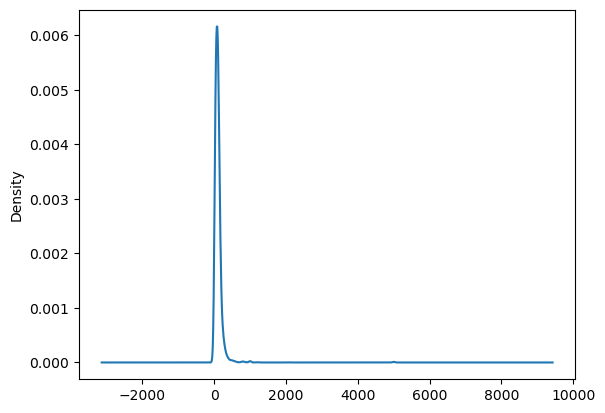

In [19]:
listings.price.plot.kde();

Revisamos los máximos

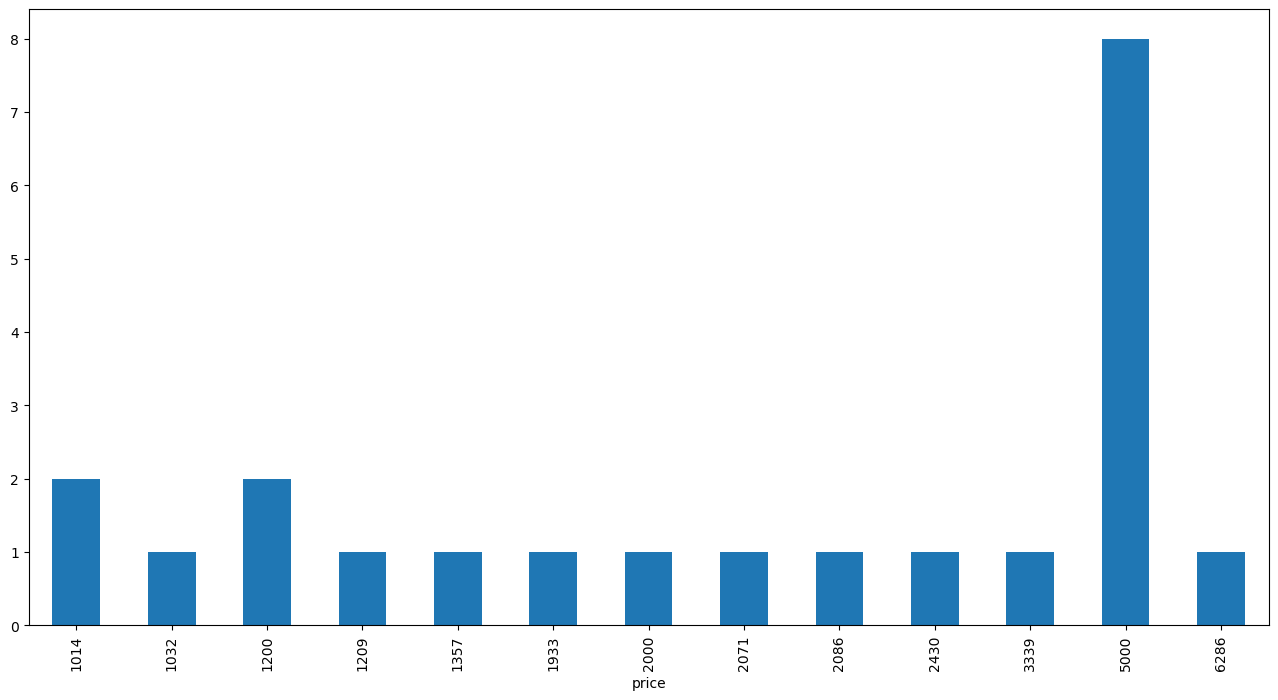

In [30]:
plt.figure(figsize=(16,8))
listings.price.loc[listings.price > 1000].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

Conclusión: 
    
**Vemos que hay varios alojamientos cuyo precio por noche es mayor de 1000, vamos a ver que ocurre**

In [31]:
listings.loc[listings.price >1000]

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
216,3275634,Home in Valencia · ★3.67 · 6 bedrooms · 10 bed...,535881,CIUTAT VELLA,EL CARME,39.477040,-0.382620,Entire home/apt,1200,1,7,361
503,8787230,Rental unit in Valencia · ★4.75 · 2 bedrooms ·...,11048105,EXTRAMURS,LA ROQUETA,39.469340,-0.383300,Entire home/apt,1014,2,5,364
635,13653671,Rental unit in València · 3 bedrooms · 3 beds ...,11048105,PATRAIX,PATRAIX,39.459300,-0.392490,Entire home/apt,1014,1,5,364
1003,18072775,Home in Valencia · ★4.86 · 4 bedrooms · 10 bed...,34677591,POBLATS DE L'OEST,BENIMAMET,39.496040,-0.427100,Entire home/apt,1357,2,5,0
1424,23139577,Rental unit in Valencia / València · ★4.35 · 3...,83066665,L'EIXAMPLE,RUSSAFA,39.462200,-0.376520,Entire home/apt,1032,1,166,281
1590,23680784,Rental unit in València · ★4.90 · 2 bedrooms ·...,104520761,L'EIXAMPLE,RUSSAFA,39.461510,-0.370670,Entire home/apt,6286,2,6,42
1606,23699863,Rental unit in València · ★4.82 · 1 bedroom · ...,177349832,L'EIXAMPLE,EL PLA DEL REMEI,39.468580,-0.367720,Entire home/apt,2071,1,2,87
1710,24956241,Rental unit in València · ★4.82 · 1 bedroom · ...,177349832,L'EIXAMPLE,EL PLA DEL REMEI,39.467110,-0.369220,Entire home/apt,2086,1,2,88
1773,25360723,Rental unit in Valencia · ★4.29 · 7 bedrooms ·...,158286946,L'EIXAMPLE,EL PLA DEL REMEI,39.467160,-0.368720,Entire home/apt,1209,2,6,290
1893,26938447,Rental unit in Valencia · 2 bedrooms · 3 beds ...,102196656,CIUTAT VELLA,EL CARME,39.478150,-0.377450,Entire home/apt,5000,1,22,364


**No vemos nada que llame la atención,ante falta de información asumimos ciertos los datos**

In [27]:
listings.groupby('neighbourhood_group').price.mean()

neighbourhood_group
ALGIROS               90.090659
BENICALAP             78.229508
BENIMACLET            81.303226
CAMINS AL GRAU       102.047927
CAMPANAR              92.690476
CIUTAT VELLA         157.250160
EL PLA DEL REAL       99.355556
EXTRAMURS            106.181287
JESUS                 81.965909
L'EIXAMPLE           139.562418
L'OLIVERETA           92.725564
LA SAIDIA             99.361039
PATRAIX               79.540541
POBLATS DE L'OEST    114.021277
POBLATS DEL NORD     123.100000
POBLATS DEL SUD      106.392045
POBLATS MARITIMS     121.823235
QUATRE CARRERES       92.973412
RASCANYA              74.082524
Name: price, dtype: float64

Revisamos los valores cercanos a cero

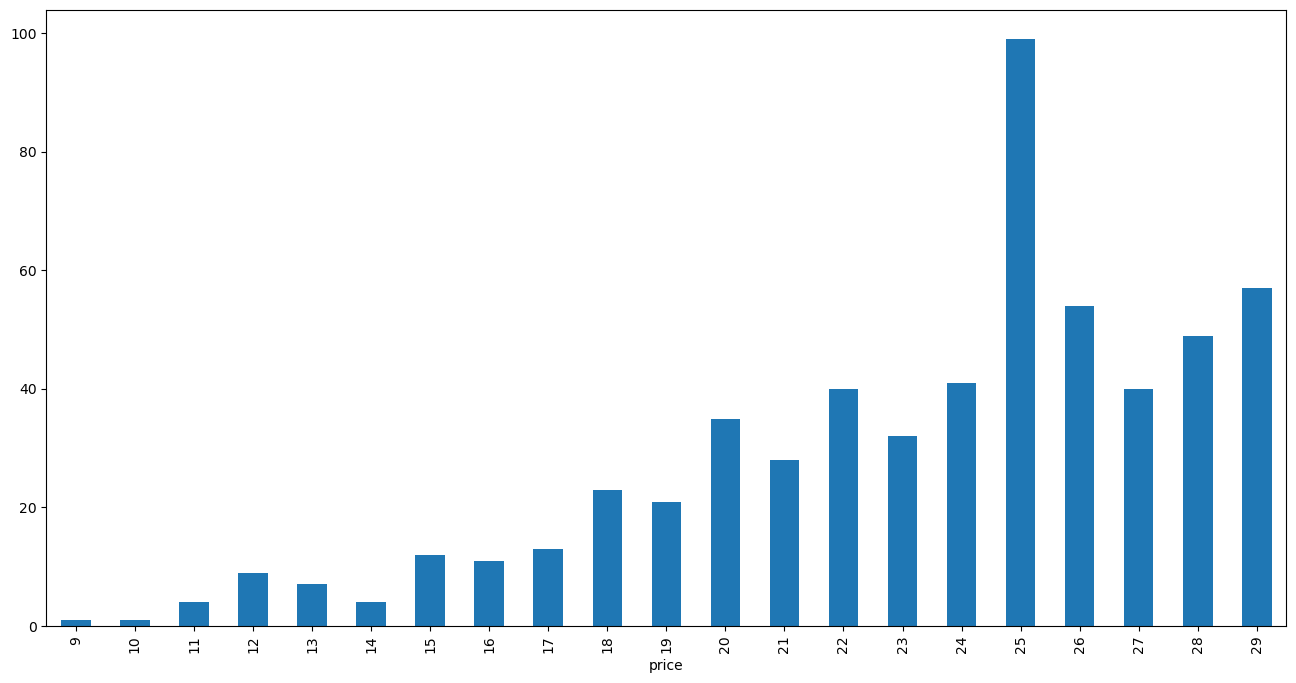

In [21]:
plt.figure(figsize=(16,8))
listings.price.loc[listings.price < 30].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

Conclusión: 
    
* Hay un pico en 25 euros, y parece que por debajo de esa cantidad sería difícil obtener rentabilidad, así que vamos a descartar los inmuebles que se alquilan por debajo de 25 euros

In [22]:
listings = listings.loc[listings.price > 24]
listings

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,48154,Rental unit in Valencia · ★4.56 · 2 bedrooms ·...,219476,LA SAIDIA,MORVEDRE,39.483750,-0.375020,Entire home/apt,89,4,4,52
1,55692,Rental unit in Valencia · 1 bedroom · 1 bed,120649,CIUTAT VELLA,LA SEU,39.476580,-0.376540,Entire home/apt,100,1,1,0
2,100347,Rental unit in València · ★4.58 · 3 bedrooms ·...,1451371,EXTRAMURS,ARRANCAPINS,39.459650,-0.384530,Entire home/apt,171,3,1,0
3,102524,Villa in Valencia · ★4.56 · 5 bedrooms · 20 be...,535881,POBLATS MARITIMS,LA MALVA-ROSA,39.481970,-0.324560,Entire home/apt,532,2,7,87
4,136378,Condo in Valencia · ★4.46 · 1 bedroom · 2 beds...,591197,CIUTAT VELLA,EL MERCAT,39.473580,-0.378150,Entire home/apt,75,28,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...
8621,980128338675751530,Rental unit in València · ★New · 4 bedrooms · ...,14579336,ALGIROS,LA CARRASCA,39.482966,-0.341721,Private room,52,14,1,269
8623,980268518716055234,Rental unit in València · ★New · 1 bedroom · 1...,521792135,L'EIXAMPLE,RUSSAFA,39.466590,-0.376320,Private room,172,2,5,27
8624,980350081270434728,Rental unit in València · ★New · 1 bedroom · 1...,418835758,BENIMACLET,BENIMACLET,39.488040,-0.357950,Private room,26,1,2,268
8625,980372458526562231,Rental unit in València · ★New · 2 bedrooms · ...,125037312,CIUTAT VELLA,SANT FRANCESC,39.470253,-0.378285,Entire home/apt,85,30,20,268


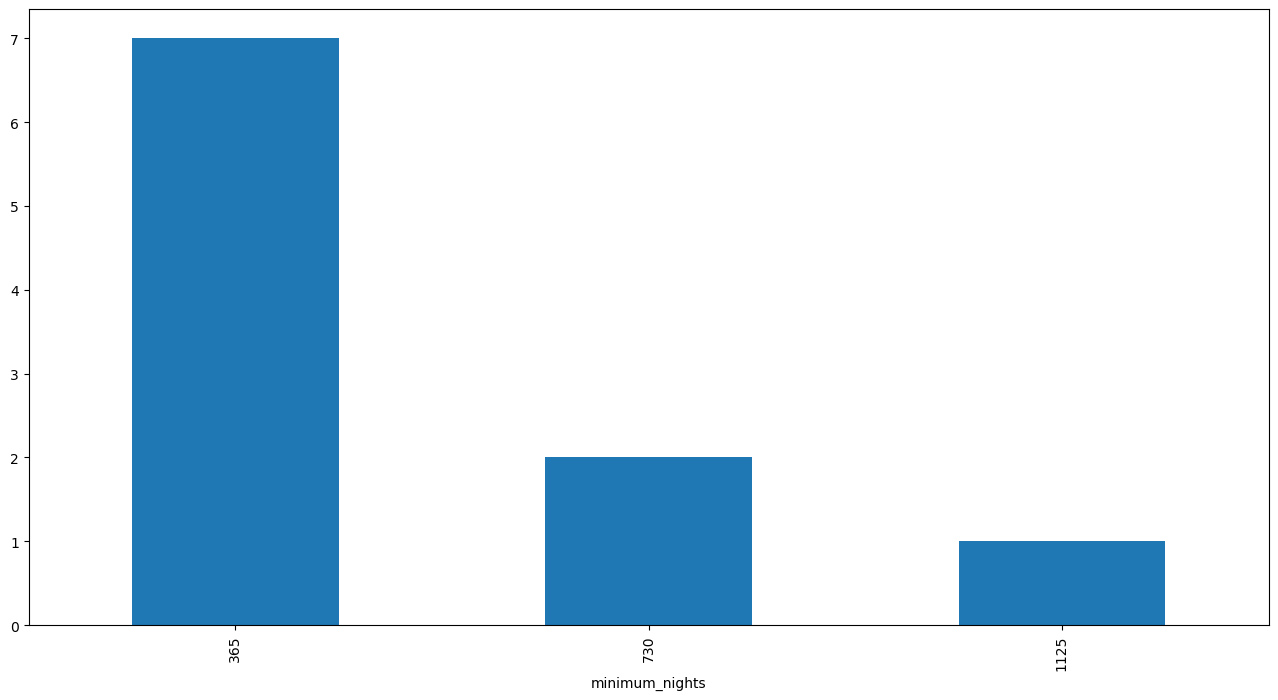

In [23]:
plt.figure(figsize=(16,8))
listings.minimum_nights.loc[listings.minimum_nights > 360].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

Para minimum_nights  descartamos aquellos que se requiera más de 365 dias, ya que nuestra prioridad es alquiler turístico

In [24]:
listings = listings.loc[listings.minimum_nights < 366]
listings

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,calculated_host_listings_count,availability_365
0,48154,Rental unit in Valencia · ★4.56 · 2 bedrooms ·...,219476,LA SAIDIA,MORVEDRE,39.483750,-0.375020,Entire home/apt,89,4,4,52
1,55692,Rental unit in Valencia · 1 bedroom · 1 bed,120649,CIUTAT VELLA,LA SEU,39.476580,-0.376540,Entire home/apt,100,1,1,0
2,100347,Rental unit in València · ★4.58 · 3 bedrooms ·...,1451371,EXTRAMURS,ARRANCAPINS,39.459650,-0.384530,Entire home/apt,171,3,1,0
3,102524,Villa in Valencia · ★4.56 · 5 bedrooms · 20 be...,535881,POBLATS MARITIMS,LA MALVA-ROSA,39.481970,-0.324560,Entire home/apt,532,2,7,87
4,136378,Condo in Valencia · ★4.46 · 1 bedroom · 2 beds...,591197,CIUTAT VELLA,EL MERCAT,39.473580,-0.378150,Entire home/apt,75,28,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...
8621,980128338675751530,Rental unit in València · ★New · 4 bedrooms · ...,14579336,ALGIROS,LA CARRASCA,39.482966,-0.341721,Private room,52,14,1,269
8623,980268518716055234,Rental unit in València · ★New · 1 bedroom · 1...,521792135,L'EIXAMPLE,RUSSAFA,39.466590,-0.376320,Private room,172,2,5,27
8624,980350081270434728,Rental unit in València · ★New · 1 bedroom · 1...,418835758,BENIMACLET,BENIMACLET,39.488040,-0.357950,Private room,26,1,2,268
8625,980372458526562231,Rental unit in València · ★New · 2 bedrooms · ...,125037312,CIUTAT VELLA,SANT FRANCESC,39.470253,-0.378285,Entire home/apt,85,30,20,268


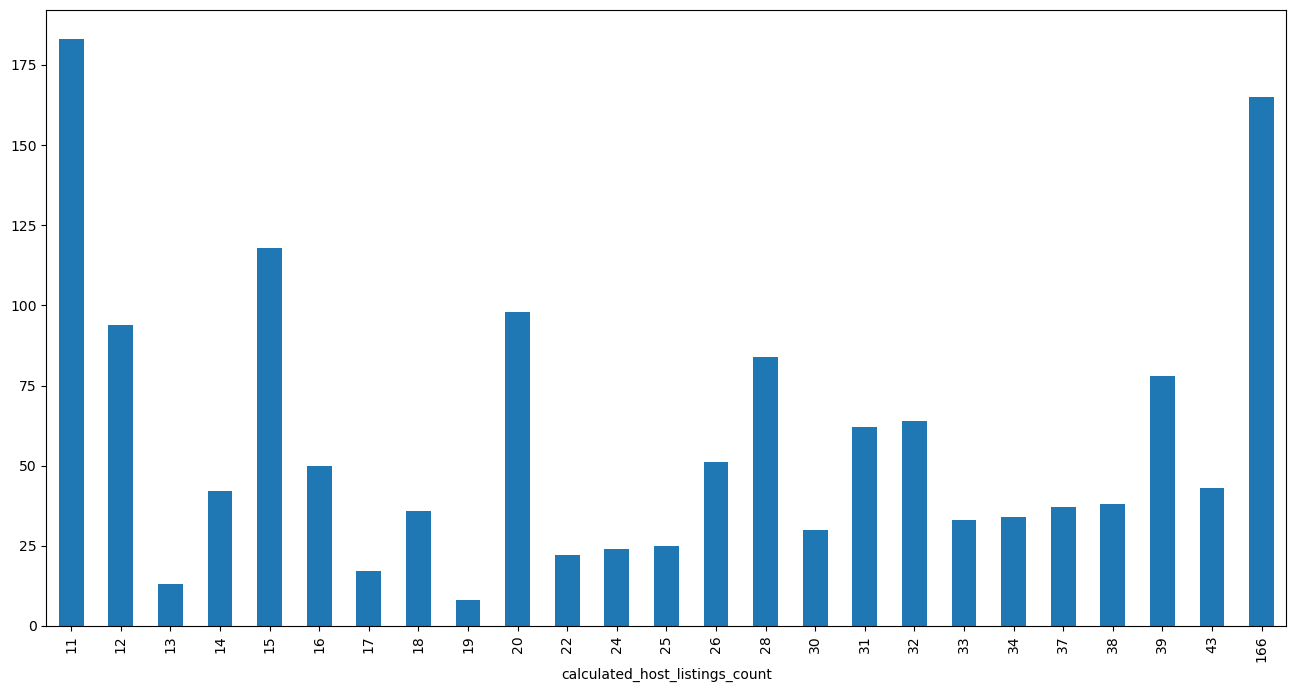

In [25]:
plt.figure(figsize=(16,8))
listings.calculated_host_listings_count.loc[listings.calculated_host_listings_count > 10].value_counts().sort_index().plot.bar()
plt.xticks(size = 10);

Sobre calculated_host_listings_count, vemos que hay un host con  166 apartamentos, supondremos que es una agencia 

### Tabla listings_det

#### Visión general

In [26]:
listings_det.head()

,index,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,0,48154,https://www.airbnb.com/rooms/48154,20230916061030,2023-09-16,city scrape,Rental unit in Valencia · ★4.56 · 2 bedrooms ·...,Segundo piso en una finca de finales del siglo...,Barrio muy cercano al casco histórico de la ci...,https://a0.muscache.com/pictures/1109085/9c0d4...,...,4.74,4.43,4.49,VT-41540-V,f,4,4,0,0,0.87
1,1,55692,https://www.airbnb.com/rooms/55692,20230916061030,2023-09-16,previous scrape,Rental unit in Valencia · 1 bedroom · 1 bed,A great place to stay and visit Valencia.<br /...,None,https://a0.muscache.com/pictures/329316/a5d6a7...,...,5.00,5.00,5.00,None,f,1,1,0,0,0.01
2,2,100347,https://www.airbnb.com/rooms/100347,20230916061030,2023-09-16,previous scrape,Rental unit in València · ★4.58 · 3 bedrooms ·...,Te va a encantar mi espacio por la ubicación y...,"Barrio de Jesús, cercano al centro, zona conso...",https://a0.muscache.com/pictures/b0bb18e8-1f24...,...,4.88,4.79,4.61,None,f,1,1,0,0,2.02
3,3,102524,https://www.airbnb.com/rooms/102524,20230916061030,2023-09-16,city scrape,Villa in Valencia · ★4.56 · 5 bedrooms · 20 be...,"JUST FOR RELAXED GROUPS. , just families. <br ...","Más de 100 restaurantes, terrazas.<br />2 supe...",https://a0.muscache.com/pictures/d2019707-1596...,...,4.69,4.81,4.38,VT-36438-V,f,7,6,1,0,1.36
4,4,136378,https://www.airbnb.com/rooms/136378,20230916061030,2023-09-16,previous scrape,Condo in Valencia · ★4.46 · 1 bedroom · 2 beds...,<b>The space</b><br />The apartment at Calle R...,None,https://a0.muscache.com/pictures/pro_photo_too...,...,4.80,4.84,4.56,VT-42161-V,f,3,3,0,0,0.17


In [27]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8627 entries, 0 to 8626
Data columns (total 76 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   index                                         8627 non-null   int64  
 1   id                                            8627 non-null   int64  
 2   listing_url                                   8627 non-null   object 
 3   scrape_id                                     8627 non-null   int64  
 4   last_scraped                                  8627 non-null   object 
 5   source                                        8627 non-null   object 
 6   name                                          8627 non-null   object 
 7   description                                   8463 non-null   object 
 8   neighborhood_overview                         4538 non-null   object 
 9   picture_url                                   8627 non-null   o

#### Variables y tipos

Vamos a seleccionar solo aquellas variables que nos aporten información relevante para nuestros objetivos.

In [28]:
a_incluir = ['id',
              'description',
              'host_is_superhost',
              'accommodates',
              'bathrooms',
              'bedrooms',
              'beds',
              'number_of_reviews',
              'review_scores_rating',
              'review_scores_communication',
              'review_scores_location'
             ]

listings_det = listings_det.loc[:,a_incluir]

listings_det

,id,description,host_is_superhost,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location
0,48154,Segundo piso en una finca de finales del siglo...,f,4,NaN,2.0,2.0,137,4.56,4.74,4.43
1,55692,A great place to stay and visit Valencia.<br /...,f,3,NaN,1.0,1.0,1,5.00,5.00,5.00
2,100347,Te va a encantar mi espacio por la ubicación y...,f,6,NaN,3.0,3.0,142,4.58,4.88,4.79
3,102524,"JUST FOR RELAXED GROUPS. , just families. <br ...",f,16,NaN,5.0,20.0,197,4.56,4.69,4.81
4,136378,<b>The space</b><br />The apartment at Calle R...,f,3,NaN,1.0,2.0,25,4.46,4.80,4.84
...,...,...,...,...,...,...,...,...,...,...,...
8622,980266361558300871,"Hola! Somos Clara y Ana, alójate en nuestra ca...",f,1,NaN,1.0,1.0,0,NaN,NaN,NaN
8623,980268518716055234,Feel at home in my beautiful casa right in the...,f,2,NaN,1.0,1.0,0,NaN,NaN,NaN
8624,980350081270434728,"Hola! Somos Clara y Ana, alójate en nuestra ca...",f,1,NaN,1.0,1.0,0,NaN,NaN,NaN
8625,980372458526562231,"Apartamento con capacidad para 3 personas, en ...",f,3,NaN,2.0,2.0,0,NaN,NaN,NaN


Analizamos los tipos

In [29]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8627 entries, 0 to 8626
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           8627 non-null   int64  
 1   description                  8463 non-null   object 
 2   host_is_superhost            8450 non-null   object 
 3   accommodates                 8627 non-null   int64  
 4   bathrooms                    0 non-null      float64
 5   bedrooms                     5707 non-null   float64
 6   beds                         8585 non-null   float64
 7   number_of_reviews            8627 non-null   int64  
 8   review_scores_rating         7540 non-null   float64
 9   review_scores_communication  7530 non-null   float64
 10  review_scores_location       7530 non-null   float64
dtypes: float64(6), int64(3), object(2)
memory usage: 741.5+ KB


Conclusión: pasar host_is_superhost a categórica.

In [30]:
listings_det['host_is_superhost'] = listings_det['host_is_superhost'].astype('category')
    
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8627 entries, 0 to 8626
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           8627 non-null   int64   
 1   description                  8463 non-null   object  
 2   host_is_superhost            8450 non-null   category
 3   accommodates                 8627 non-null   int64   
 4   bathrooms                    0 non-null      float64 
 5   bedrooms                     5707 non-null   float64 
 6   beds                         8585 non-null   float64 
 7   number_of_reviews            8627 non-null   int64   
 8   review_scores_rating         7540 non-null   float64 
 9   review_scores_communication  7530 non-null   float64 
 10  review_scores_location       7530 non-null   float64 
dtypes: category(1), float64(6), int64(3), object(1)
memory usage: 682.7+ KB


#### Análisis de nulos

In [31]:
listings_det.isna().sum()

id                                0
description                     164
host_is_superhost               177
accommodates                      0
bathrooms                      8627
bedrooms                       2920
beds                             42
number_of_reviews                 0
review_scores_rating           1087
review_scores_communication    1097
review_scores_location         1097
dtype: int64

Conclusiones:

* bathrooms está totalmente a nulos, por tanto la eliminamos
* description no pasa nada porque tenga nulos, así que la dejamos
* host_is_superhost tiene  pocos nulos y no es una variables super relevante, así que la dejamos
* beds: podemos intentar imputarla a partir de accomodates
* bedrooms sí es una variable importante para nosotros, podemos intentar imputar los nulos a través de proxies como accomodates o beds

Vamos a ver si podemos hacer una imputación de beds a partir del número de personas que se pueden acomodar.

In [32]:
pd.crosstab(listings_det.beds, listings_det.accommodates)

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
beds,,,,,,,,,,,,,,,,
1.0,952,2251,147,173,4,4,0,0,0,0,0,0,0,0,0,0
2.0,40,373,487,1101,67,36,1,2,0,0,0,0,0,0,0,0
3.0,4,20,81,729,346,315,12,11,0,0,1,0,0,0,0,0
4.0,7,7,23,152,228,318,52,67,5,0,0,1,0,0,0,0
5.0,1,0,1,17,36,146,40,54,6,8,1,0,0,0,0,0
6.0,1,3,0,5,9,32,13,62,8,6,2,4,0,0,0,0
7.0,1,0,1,0,1,2,3,24,2,7,1,1,0,0,0,0
8.0,1,1,0,0,0,0,0,7,2,6,3,2,0,0,0,1
9.0,0,0,0,0,0,1,0,3,0,3,4,2,0,0,0,1


Parece que sí podríamos hacer una asignación mas o menos directa. Leyendo la matriz en vertical vemos que:

* una o dos personas se suelen corresponder con una cama
* tres o cuatro personas se suelen corresponder con dos camas
* cinco o seis personas se suelen corresponder con tres camas
* a más de 6 personas le vamos a poner cuatro camas

Repasamos el número de nulos y la frecuencia de cada valor

In [33]:
listings_det['beds'].value_counts(dropna = False)

beds
1.0     3531
2.0     2107
3.0     1519
4.0      860
5.0      310
6.0      145
7.0       43
NaN       42
8.0       23
9.0       14
10.0       8
11.0       5
14.0       3
22.0       3
18.0       2
13.0       2
19.0       2
68.0       1
30.0       1
17.0       1
15.0       1
23.0       1
12.0       1
20.0       1
40.0       1
Name: count, dtype: int64

Creamos una función para imputar los nulos de beds en base a accommodates

In [34]:
def imputar_nulos(registro):
    #Lista de condiciones
    condiciones = [(registro.accommodates <= 2),
               (registro.accommodates > 2) & (registro.accommodates <= 4),
               (registro.accommodates > 4) & (registro.accommodates <= 6),
               (registro.accommodates > 6)]

    #Lista de resultados
    resultados = [1,2,3,4]
    
    #Salida
    return(np.select(condiciones,resultados, default = -999))

#Imputación
listings_det.loc[listings_det.beds.isna(),'beds'] = listings_det.loc[listings_det.beds.isna()].apply(imputar_nulos, axis = 1).astype('float64')


Comprobamos

In [35]:
listings_det.beds.value_counts(dropna = False)

beds
1.0     3558
2.0     2119
3.0     1521
4.0      861
5.0      310
6.0      145
7.0       43
8.0       23
9.0       14
10.0       8
11.0       5
14.0       3
22.0       3
13.0       2
19.0       2
18.0       2
20.0       1
15.0       1
12.0       1
23.0       1
68.0       1
17.0       1
30.0       1
40.0       1
Name: count, dtype: int64

Ahora vamos a ver si podemos hacer una imputación de bedrooms.

Empezamos por cruzar el número de habitaciones con el número de personas que se pueden acomodar.

In [36]:
pd.crosstab(listings_det.bedrooms, listings_det.accommodates)

accommodates,1,2,3,4,5,6,7,8,9,10,11,12,14,15,16
bedrooms,,,,,,,,,,,,,,,
1.0,66,952,359,747,31,36,0,7,0,0,0,1,0,0,0
2.0,2,51,199,1081,247,287,13,12,5,1,1,0,0,0,1
3.0,0,4,18,228,347,433,55,109,5,5,1,1,0,0,1
4.0,1,2,0,17,38,86,44,86,7,6,4,5,3,0,5
5.0,0,0,0,1,7,2,6,13,5,13,5,3,0,0,3
6.0,0,0,0,1,0,0,0,4,2,4,3,4,1,1,2
7.0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,2
8.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
15.0,3,6,0,0,0,0,0,0,0,0,0,0,0,0,0


No parece muy fiable.

Vamos a contrastarlo con el número de camas.

In [37]:
pd.crosstab(listings_det.bedrooms, listings_det.beds, dropna=False)

beds,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,...,15.0,17.0,18.0,19.0,20.0,22.0,23.0,30.0,40.0,68.0
bedrooms,,,,,,,,,,,,,,,,,,,,,
1.0,1149,863,132,46,4,4,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2.0,31,808,766,247,31,13,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
3.0,6,16,544,370,180,69,14,4,2,1,...,0,0,0,1,0,0,0,0,0,0
4.0,1,1,5,159,60,34,18,9,3,4,...,0,0,2,0,0,1,1,1,0,0
5.0,0,1,1,1,29,7,5,5,5,0,...,0,0,0,1,1,0,0,0,0,0
6.0,0,1,0,0,0,12,1,2,2,1,...,0,0,0,0,0,0,0,0,0,0
7.0,0,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,1,0,0,0,0
8.0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15.0,5,4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Aquí sí podríamos hacer una asignación más directa. Leyendo la matriz en vertical vemos que:

*  una o dos camas se suele corresponder con una habitación
* tres  se suele corresponder con dos habitaciones
* cuatro o cinco camas se suele corresponder con tres habitaciones
* a más camas le vamos a poner cuatro habitaciones

Vamos a modificar la función que habíamos creado para imputar los nulos de bedrooms a partir de beds.

Primero hacemos el conteo de bedrooms

In [38]:
listings_det.bedrooms.value_counts(dropna = False)

bedrooms
NaN     2920
1.0     2199
2.0     1900
3.0     1207
4.0      304
5.0       58
6.0       22
15.0       9
7.0        5
8.0        1
45.0       1
17.0       1
Name: count, dtype: int64

Ejecutamos la función actualizada

In [39]:
def imputar_nulos(registro):
    #Lista de condiciones
    condiciones = [(registro.beds <= 2),
               (registro.beds > 2) & (registro.beds <= 3) ,
               (registro.beds >= 4) & (registro.beds <= 5),
               (registro.beds > 5)]

    #Lista de resultados
    resultados = [1,2,3,4]
    
    #Salida
    return(np.select(condiciones,resultados, default = -999))

#Imputación
listings_det.loc[listings_det.bedrooms.isna(),'bedrooms'] = listings_det.loc[listings_det.bedrooms.isna()].apply(imputar_nulos, axis = 1).astype('float64')

Comprobamos

In [40]:
listings_det.bedrooms.value_counts(dropna = False)

bedrooms
1.0     4990
2.0     1972
3.0     1251
4.0      317
5.0       58
6.0       22
15.0       9
7.0        5
8.0        1
45.0       1
17.0       1
Name: count, dtype: int64

Por último vamos a eliminar bathrooms

In [41]:
listings_det.drop(columns = 'bathrooms', inplace = True)
listings_det

,id,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location
0,48154,Segundo piso en una finca de finales del siglo...,f,4,2.0,2.0,137,4.56,4.74,4.43
1,55692,A great place to stay and visit Valencia.<br /...,f,3,1.0,1.0,1,5.00,5.00,5.00
2,100347,Te va a encantar mi espacio por la ubicación y...,f,6,3.0,3.0,142,4.58,4.88,4.79
3,102524,"JUST FOR RELAXED GROUPS. , just families. <br ...",f,16,5.0,20.0,197,4.56,4.69,4.81
4,136378,<b>The space</b><br />The apartment at Calle R...,f,3,1.0,2.0,25,4.46,4.80,4.84
...,...,...,...,...,...,...,...,...,...,...
8622,980266361558300871,"Hola! Somos Clara y Ana, alójate en nuestra ca...",f,1,1.0,1.0,0,NaN,NaN,NaN
8623,980268518716055234,Feel at home in my beautiful casa right in the...,f,2,1.0,1.0,0,NaN,NaN,NaN
8624,980350081270434728,"Hola! Somos Clara y Ana, alójate en nuestra ca...",f,1,1.0,1.0,0,NaN,NaN,NaN
8625,980372458526562231,"Apartamento con capacidad para 3 personas, en ...",f,3,2.0,2.0,0,NaN,NaN,NaN


#### Análisis de duplicados

Comprobamos si hay algún registro duplicado

In [42]:
listings_det.duplicated().sum()

0

In [43]:
listings_det.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8627 entries, 0 to 8626
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   id                           8627 non-null   int64   
 1   description                  8463 non-null   object  
 2   host_is_superhost            8450 non-null   category
 3   accommodates                 8627 non-null   int64   
 4   bedrooms                     8627 non-null   float64 
 5   beds                         8627 non-null   float64 
 6   number_of_reviews            8627 non-null   int64   
 7   review_scores_rating         7540 non-null   float64 
 8   review_scores_communication  7530 non-null   float64 
 9   review_scores_location       7530 non-null   float64 
dtypes: category(1), float64(5), int64(3), object(1)
memory usage: 615.3+ KB


#### Análisis de variables categóricas

Vamos a analizar los valores y las frecuencias de las variables categóricas

In [44]:
listings_det.host_is_superhost.value_counts()

host_is_superhost
f    6494
t    1956
Name: count, dtype: int64

#### Análisis de variables numéricas

In [45]:
listings_det.describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
id,8627.0,4.258098e+17,4.146847e+17,48154.0,31825655.00,5.804662e+17,8.535716e+17,9.805602e+17
accommodates,8627.0,3.457981e+00,1.964250e+00,1.0,2.00,3.000000e+00,4.000000e+00,1.600000e+01
bedrooms,8627.0,1.694332e+00,1.146217e+00,1.0,1.00,1.000000e+00,2.000000e+00,4.500000e+01
beds,8627.0,2.248986e+00,1.782621e+00,1.0,1.00,2.000000e+00,3.000000e+00,6.800000e+01
number_of_reviews,8627.0,4.296685e+01,7.278495e+01,0.0,3.00,1.300000e+01,4.900000e+01,8.070000e+02
review_scores_rating,7540.0,4.613336e+00,4.902174e-01,0.0,4.50,4.730000e+00,4.900000e+00,5.000000e+00
review_scores_communication,7530.0,4.765733e+00,4.145406e-01,1.0,4.72,4.890000e+00,5.000000e+00,5.000000e+00
review_scores_location,7530.0,4.673964e+00,4.012667e-01,1.0,4.55,4.780000e+00,4.930000e+00,5.000000e+00


No vemos nada extraño.

En este punto ya hemos detectado y corregido los principales problemas de calidad de datos así que pasamos a crear el datamart analítico integrando nuestras tablas.

## DATAMART ANALITICO

Tenemos 2 tablas principales:

* listings
* listings_det

Y sabemos que ambas comparten el campo id, por tanto podemos cruzarlas por él.

La tabla principal es listings, ya que la de detalle lo que hace es darnos datos adicionales.

Por tanto la tabla que ha de mandar en la integración es listings.

Además tambien tenemos la tabla del precio, que en este caso cruza conceptualmente con listings a través del distrito (neighbourhood_group).

Aunque no hemos comprobado todavía que los literales sean iguales, por tanto quizá será necesario hacer alguna corrección manual.

Vamos a empezar por las 2 principales.

Dado que va a mandar la tabla listings el resultado final tendrá que tener tantas filas como listings y tantas columnas como las de ambas tablas (menos 1 por el id que se quedará como una única variable)

In [46]:
listings.shape

(8324, 12)

In [47]:
listings_det.shape

(8627, 10)

In [48]:
df = pd.merge(left = listings, right = listings_det, how = 'left', on = 'id')
df

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,availability_365,description,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location
0,48154,Rental unit in Valencia · ★4.56 · 2 bedrooms ·...,219476,LA SAIDIA,MORVEDRE,39.483750,-0.375020,Entire home/apt,89,4,...,52,Segundo piso en una finca de finales del siglo...,f,4,2.0,2.0,137,4.56,4.74,4.43
1,55692,Rental unit in Valencia · 1 bedroom · 1 bed,120649,CIUTAT VELLA,LA SEU,39.476580,-0.376540,Entire home/apt,100,1,...,0,A great place to stay and visit Valencia.<br /...,f,3,1.0,1.0,1,5.00,5.00,5.00
2,100347,Rental unit in València · ★4.58 · 3 bedrooms ·...,1451371,EXTRAMURS,ARRANCAPINS,39.459650,-0.384530,Entire home/apt,171,3,...,0,Te va a encantar mi espacio por la ubicación y...,f,6,3.0,3.0,142,4.58,4.88,4.79
3,102524,Villa in Valencia · ★4.56 · 5 bedrooms · 20 be...,535881,POBLATS MARITIMS,LA MALVA-ROSA,39.481970,-0.324560,Entire home/apt,532,2,...,87,"JUST FOR RELAXED GROUPS. , just families. <br ...",f,16,5.0,20.0,197,4.56,4.69,4.81
4,136378,Condo in Valencia · ★4.46 · 1 bedroom · 2 beds...,591197,CIUTAT VELLA,EL MERCAT,39.473580,-0.378150,Entire home/apt,75,28,...,6,<b>The space</b><br />The apartment at Calle R...,f,3,1.0,2.0,25,4.46,4.80,4.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8319,980128338675751530,Rental unit in València · ★New · 4 bedrooms · ...,14579336,ALGIROS,LA CARRASCA,39.482966,-0.341721,Private room,52,14,...,269,"Lovely apartment, completely renovated, close ...",f,2,4.0,4.0,0,NaN,NaN,NaN
8320,980268518716055234,Rental unit in València · ★New · 1 bedroom · 1...,521792135,L'EIXAMPLE,RUSSAFA,39.466590,-0.376320,Private room,172,2,...,27,Feel at home in my beautiful casa right in the...,f,2,1.0,1.0,0,NaN,NaN,NaN
8321,980350081270434728,Rental unit in València · ★New · 1 bedroom · 1...,418835758,BENIMACLET,BENIMACLET,39.488040,-0.357950,Private room,26,1,...,268,"Hola! Somos Clara y Ana, alójate en nuestra ca...",f,1,1.0,1.0,0,NaN,NaN,NaN
8322,980372458526562231,Rental unit in València · ★New · 2 bedrooms · ...,125037312,CIUTAT VELLA,SANT FRANCESC,39.470253,-0.378285,Entire home/apt,85,30,...,268,"Apartamento con capacidad para 3 personas, en ...",f,3,2.0,2.0,0,NaN,NaN,NaN


Ahora vamos a ver cómo podemos incorporar la información externa del precio por metro cuadrado.

Para ello lo primero es analizar los valores de la variable distrito en ambas tablas, ya que necesitan coincidir para que podamos cruzarlos.



In [49]:
distritos1 = df.neighbourhood_group.value_counts().sort_index()
distritos1

neighbourhood_group
ALGIROS               338
BENICALAP             168
BENIMACLET            140
CAMINS AL GRAU        734
CAMPANAR              114
CIUTAT VELLA         1546
EL PLA DEL REAL       173
EXTRAMURS             667
JESUS                 253
L'EIXAMPLE            752
L'OLIVERETA           250
LA SAIDIA             367
PATRAIX               168
POBLATS DE L'OEST      40
POBLATS DEL NORD        9
POBLATS DEL SUD       174
POBLATS MARITIMS     1577
QUATRE CARRERES       662
RASCANYA              192
Name: count, dtype: int64

In [50]:
distritos2 = precio_m2.distrito
distritos2

1              Algirós
2            Benicalap
3             Campanar
4         Ciutat Vella
5      El Pla del Real
6            Extramurs
7                Jesús
8           L'Eixample
9          L'Olivereta
10             Patraix
11    Poblats Marítims
12     Quatre Carreres
13            Rascanya
Name: distrito, dtype: object

Comparando vemos que falta información en nuestra tabla de precio_m2, incorporamos los últimos precios informados en idealista, como no disponemos de informacion de "POBLATS DE L'OEST ","POBLATS DEL NORD","POBLATS DEL SUD", lo imputaremos por el precio de POBLATS MARITIMS



In [51]:
nuevo_precios = pd.DataFrame({
                 'precio_m2': [2081,2232,1951,2168,2168,2168],
                 'distrito': ['BENIMACLET', 'CAMINS AL GRAU', 'LA SAIDIA', "POBLATS DE L'OEST","POBLATS DEL NORD","POBLATS DEL SUD"]
})

# Añadimos la nueva fila al dataframe
precio_m2 = pd.concat([precio_m2, nuevo_precios], ignore_index=True)

In [52]:
precio_m2

,precio_m2,distrito
0,2273,Algirós
1,1811,Benicalap
2,2736,Campanar
3,3255,Ciutat Vella
4,2993,El Pla del Real
5,2670,Extramurs
6,1781,Jesús
7,3513,L'Eixample
8,1650,L'Olivereta
9,1852,Patraix


In [53]:
precio_m2.distrito.value_counts()

distrito
Algirós              1
Poblats Marítims     1
POBLATS DEL NORD     1
POBLATS DE L'OEST    1
LA SAIDIA            1
CAMINS AL GRAU       1
BENIMACLET           1
Rascanya             1
Quatre Carreres      1
Patraix              1
Benicalap            1
L'Olivereta          1
L'Eixample           1
Jesús                1
Extramurs            1
El Pla del Real      1
Ciutat Vella         1
Campanar             1
POBLATS DEL SUD      1
Name: count, dtype: int64

Por tanto vamos a reemplazar estos valores en precio_m2 para que sean iguales a los de df y podamos cruzarlos

In [54]:
precio_m2.distrito = precio_m2.distrito.map({'Algirós':'ALGIROS',
                                            'Benicalap':'BENICALAP',
                                            'Campanar':'CAMPANAR',
                                             'Ciutat Vella':'CIUTAT VELLA',
                                             'El Pla del Real':'EL PLA DEL REAL',
                                             'Extramurs':'EXTRAMURS',
                                             'Jesús':'JESUS',
                                             "L'Eixample" :"L'EIXAMPLE",
                                             "L'Olivereta":"L'OLIVERETA",
                                             "Patraix":"PATRAIX",
                                             "Poblats Marítims":"POBLATS MARITIMS",
                                             "Quatre Carreres":"QUATRE CARRERES",
                                             "Rascanya":"RASCANYA",     
                                            }) \
                    .fillna(precio_m2.distrito)

precio_m2

,precio_m2,distrito
0,2273,ALGIROS
1,1811,BENICALAP
2,2736,CAMPANAR
3,3255,CIUTAT VELLA
4,2993,EL PLA DEL REAL
5,2670,EXTRAMURS
6,1781,JESUS
7,3513,L'EIXAMPLE
8,1650,L'OLIVERETA
9,1852,PATRAIX


Ahora sí que ya podemos cruzarlos.

Manda df.

In [55]:
df = pd.merge(left = df, right = precio_m2, how = 'left', left_on='neighbourhood_group', right_on='distrito')
df

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,host_is_superhost,accommodates,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_communication,review_scores_location,precio_m2,distrito
0,48154,Rental unit in Valencia · ★4.56 · 2 bedrooms ·...,219476,LA SAIDIA,MORVEDRE,39.483750,-0.375020,Entire home/apt,89,4,...,f,4,2.0,2.0,137,4.56,4.74,4.43,1951,LA SAIDIA
1,55692,Rental unit in Valencia · 1 bedroom · 1 bed,120649,CIUTAT VELLA,LA SEU,39.476580,-0.376540,Entire home/apt,100,1,...,f,3,1.0,1.0,1,5.00,5.00,5.00,3255,CIUTAT VELLA
2,100347,Rental unit in València · ★4.58 · 3 bedrooms ·...,1451371,EXTRAMURS,ARRANCAPINS,39.459650,-0.384530,Entire home/apt,171,3,...,f,6,3.0,3.0,142,4.58,4.88,4.79,2670,EXTRAMURS
3,102524,Villa in Valencia · ★4.56 · 5 bedrooms · 20 be...,535881,POBLATS MARITIMS,LA MALVA-ROSA,39.481970,-0.324560,Entire home/apt,532,2,...,f,16,5.0,20.0,197,4.56,4.69,4.81,2168,POBLATS MARITIMS
4,136378,Condo in Valencia · ★4.46 · 1 bedroom · 2 beds...,591197,CIUTAT VELLA,EL MERCAT,39.473580,-0.378150,Entire home/apt,75,28,...,f,3,1.0,2.0,25,4.46,4.80,4.84,3255,CIUTAT VELLA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8319,980128338675751530,Rental unit in València · ★New · 4 bedrooms · ...,14579336,ALGIROS,LA CARRASCA,39.482966,-0.341721,Private room,52,14,...,f,2,4.0,4.0,0,NaN,NaN,NaN,2273,ALGIROS
8320,980268518716055234,Rental unit in València · ★New · 1 bedroom · 1...,521792135,L'EIXAMPLE,RUSSAFA,39.466590,-0.376320,Private room,172,2,...,f,2,1.0,1.0,0,NaN,NaN,NaN,3513,L'EIXAMPLE
8321,980350081270434728,Rental unit in València · ★New · 1 bedroom · 1...,418835758,BENIMACLET,BENIMACLET,39.488040,-0.357950,Private room,26,1,...,f,1,1.0,1.0,0,NaN,NaN,NaN,2081,BENIMACLET
8322,980372458526562231,Rental unit in València · ★New · 2 bedrooms · ...,125037312,CIUTAT VELLA,SANT FRANCESC,39.470253,-0.378285,Entire home/apt,85,30,...,f,3,2.0,2.0,0,NaN,NaN,NaN,3255,CIUTAT VELLA


Comprobamos que no se hayan generado nulos en la unión.

In [56]:
df.precio_m2.isna().sum()

0

## GUARDAR EN LA BASE DE DATOS

Ahora que ya tenemos el tablón de análisis vamos a guardarlo en la base de datos para que cada vez que queramos hacer análisis no tengamos que repetir todo el procesamiento de este notebook

In [57]:
df.to_sql('df', con = con, if_exists = 'replace')

8324